In [118]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import math
import jax
import jax.numpy as jnp
import optax
from tqdm.auto import tqdm

import measure_transp as mt

In [120]:
importlib.reload(mt)

<module 'measure_transp' from '/Users/lucaraffo/Desktop/Measure_Transport/measure_transp.py'>

In [104]:
t = np.array([1, 2, 3, 4, 5], dtype=float)
y = np.array([0.18, 0.32, 0.42, 0.49, 0.54], dtype=float)
sigma_2 = 1e-3

step_list = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
steps, rates = mt.run_acceptance_table(y, t, sigma_2, step_list, n_steps=25000)

print("step size vs acceptance rate:")
for s, r in zip(steps, rates):
    print(f"  {s:.3f}  ->  {r:.3f}")

step_size = 0.1
chain, acc_rate = mt.rw_metropolis(y, t, sigma_2, n_samples=25000, step_size=step_size)

print(f"\nfinal run: step size={step_size}, acceptance rate={acc_rate:.4f}")

step size vs acceptance rate:
  0.005  ->  0.976
  0.010  ->  0.960
  0.050  ->  0.790
  0.100  ->  0.612
  0.500  ->  0.160
  1.000  ->  0.070

final run: step size=0.1, acceptance rate=0.6121


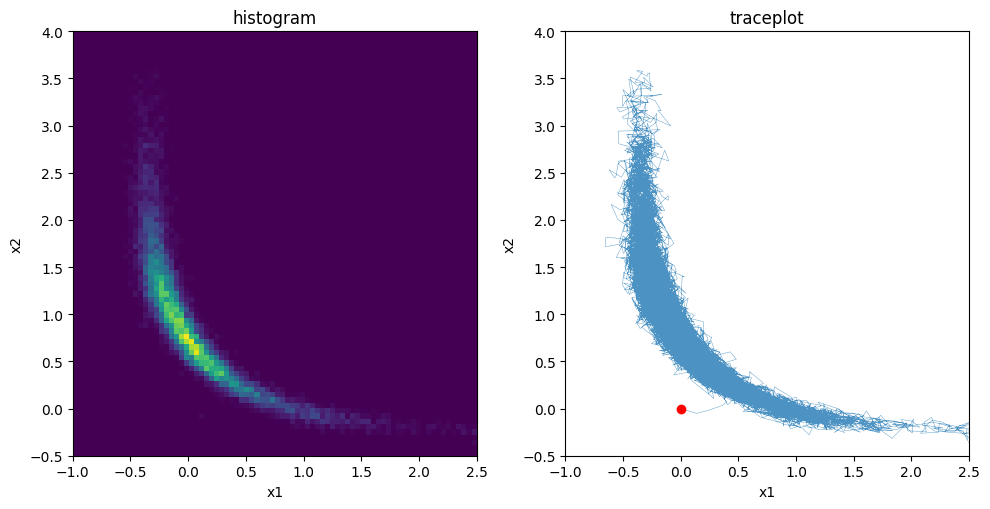

In [105]:
mt.plot_hist_and_trace(chain, start=chain[0])

In [106]:
theta1 = chain[:,0]
theta2 = chain[:,1]

m1, ci1 = mt.clt_ci_mean(theta1)
m2, ci2 = mt.clt_ci_mean(theta2)

print("\nPosterior means and 95% CIs:")
print(f"  x1: mean={m1:.4f}, CI=({ci1[0]:.4f}, {ci1[1]:.4f})")
print(f"  x2: mean={m2:.4f}, CI=({ci2[0]:.4f}, {ci2[1]:.4f})")


Posterior means and 95% CIs:
  x1: mean=0.0656, CI=(-0.0361, 0.1673)
  x2: mean=0.9209, CI=(0.7729, 1.0689)


degrees: 100%|██████████| 4/4 [08:56<00:00, 134.14s/it]


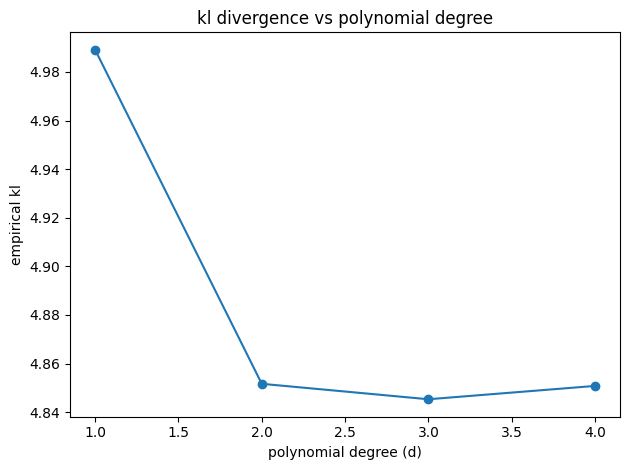

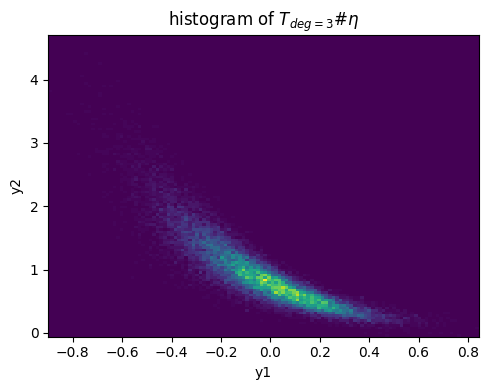

kl per degree: {1: 4.989117622375488, 2: 4.8516764640808105, 3: 4.845322608947754, 4: 4.850803852081299}
best: {'deg': 3, 'kl': 4.845322608947754}


In [110]:
# cast to float and build log g tilde
t       = np.asarray(t, dtype=float)
y       = np.asarray(y, dtype=float)
sigma_2 = float(sigma_2)
log_g_tilde = mt.make_log_g_tilde(t, y, sigma_2)

# optimization hyperparameters
degrees    = [1, 2, 3, 4]   # polynomial degrees to compare
M          = 20000          # number of prior samples η ~ n(0,i)
steps      = 3000           # training steps per degree
batch_size = 1024
lr         = 1e-2
seed       = 0

# reference samples from prior
key   = jax.random.PRNGKey(seed)
mean = jnp.array([m1, m2])
x_ref = jax.random.normal(key, (M, 2))

# storage for results
best = {'kl': np.inf, 'deg': None, 'params': None}
kls  = []

# training loop over degrees
for deg in tqdm(degrees, desc="degrees", leave=True):
    key, k_init = jax.random.split(key)
    params = mt.TriMap2D(deg, k_init)
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    pbar = tqdm(range(steps), desc=f"deg={deg}", leave=False)
    last_val = None

    for _ in pbar:
        idx = np.random.choice(M, batch_size, replace=False)
        xb  = x_ref[idx]
        params, opt_state, val = mt.train_step(params, opt_state, xb, log_g_tilde, optimizer)
        # update postfix with current loss value
        try:
            pbar.set_postfix(loss=float(val))
        except Exception:
            pass
        last_val = val

    # empirical kl (theorem 1.3)
    kl_val = mt.empirical_KL(params, x_ref, log_g_tilde)
    kls.append(float(kl_val))
    if kl_val < best['kl']:
        best = {'kl': float(kl_val), 'deg': deg, 'params': params}

# plot kl vs polynomial degree
plt.figure()
plt.plot(degrees, kls, marker='o')
plt.xlabel("polynomial degree (d)")
plt.ylabel("empirical kl")
plt.title("kl divergence vs polynomial degree")
plt.tight_layout()
plt.show()

# plot 2d histogram of transported samples for the best map
y_best, _ = best['params'].apply(x_ref)
y_best = np.asarray(y_best)
plt.figure(figsize=(5,4))
plt.hist2d(y_best[:,0], y_best[:,1], bins=120)
plt.xlabel("y1"); plt.ylabel("y2")
plt.title(f"histogram of $T_{{deg={best['deg']}}}\\#\\eta$")
plt.tight_layout()
plt.show()

print("kl per degree:", dict(zip(degrees, kls)))
print("best:", {"deg": best['deg'], "kl": best['kl']})

acceptance rate (independence via mt): 0.7050705070507051


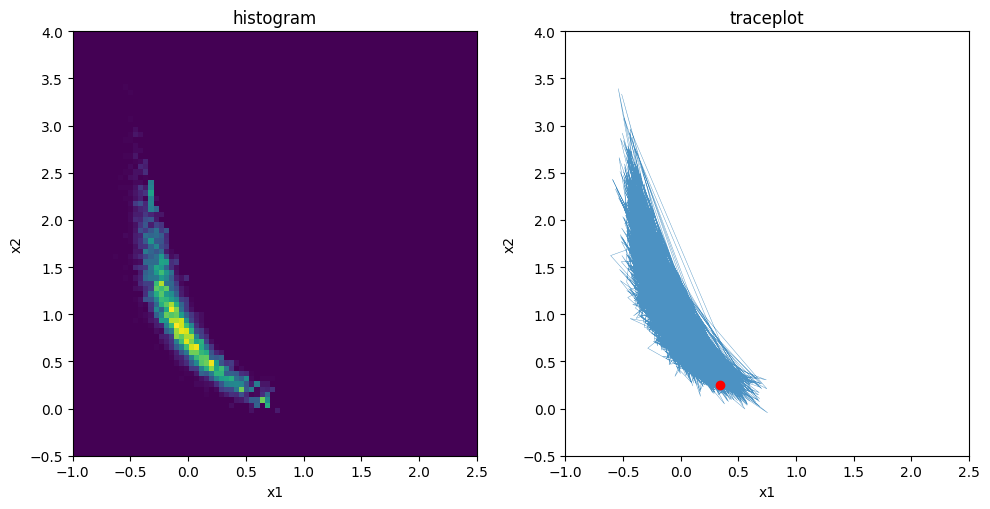

In [121]:
proposal_params = best['params']

# independence sampler
chain, acc_rate = mt.independence_sampler_MT(proposal_params, log_g_tilde,
                                          n_steps=10_000, x0=None, seed=1200)
print("acceptance rate (independence via mt):", acc_rate)

# diagnostics
mt.plot_hist_and_trace(chain, start=chain[0], xlim=(-1.0, 2.5), ylim=(-0.5, 4.0))

In [122]:
theta1 = chain[:,0]
theta2 = chain[:,1]

m1, ci1 = mt.clt_ci_mean(theta1)
m2, ci2 = mt.clt_ci_mean(theta2)

print("\nPosterior means and 95% CIs:")
print(f"  x1: mean={m1:.4f}, CI=({ci1[0]:.4f}, {ci1[1]:.4f})")
print(f"  x2: mean={m2:.4f}, CI=({ci2[0]:.4f}, {ci2[1]:.4f})")


Posterior means and 95% CIs:
  x1: mean=-0.0370, CI=(-0.0507, -0.0234)
  x2: mean=0.9876, CI=(0.9623, 1.0129)


acceptance rate (independence via mt): 0.5821832873314933


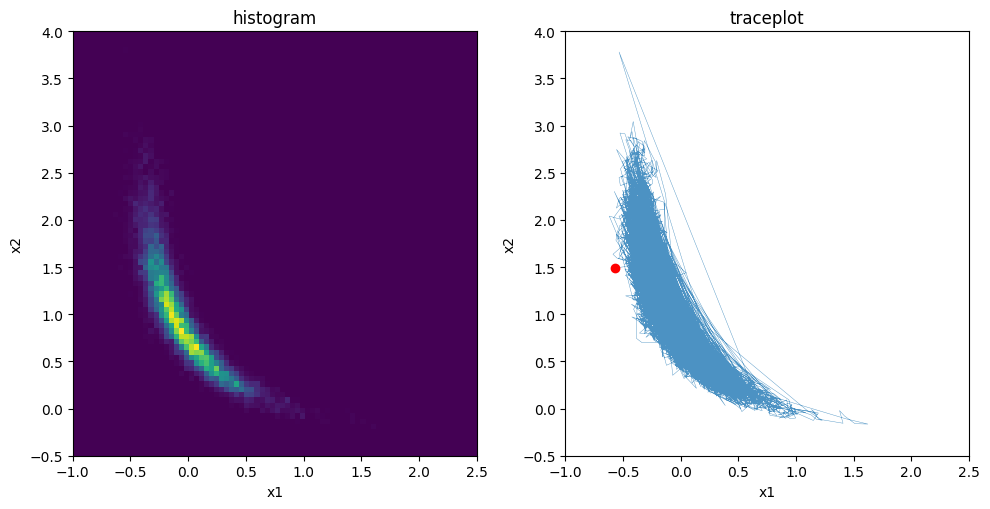

In [126]:
chain, overall_acc, rwm_acc, tmis_acc, tries_rwm, tries_tmis = mt.mixed_rw_tmis_sampler(proposal_params, log_g_tilde, gamma = 0.75)
print("acceptance rate (independence via mt):", overall_acc)

# diagnostics
mt.plot_hist_and_trace(chain, start=chain[0], xlim=(-1.0, 2.5), ylim=(-0.5, 4.0))

In [127]:
theta1 = chain[:,0]
theta2 = chain[:,1]

m1, ci1 = mt.clt_ci_mean(theta1)
m2, ci2 = mt.clt_ci_mean(theta2)

print("\nPosterior means and 95% CIs:")
print(f"  x1: mean={m1:.4f}, CI=({ci1[0]:.4f}, {ci1[1]:.4f})")
print(f"  x2: mean={m2:.4f}, CI=({ci2[0]:.4f}, {ci2[1]:.4f})")


Posterior means and 95% CIs:
  x1: mean=-0.0457, CI=(-0.0659, -0.0254)
  x2: mean=0.9744, CI=(0.9293, 1.0195)
